# Importing Liabraries

In [9]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") 
plt.style.use('fivethirtyeight')

# Importing Dataframes

In [10]:
# Importing Dataframes

import pandas as pd

df = pd.read_csv("/Users/samuellal/Downloads/Project_Citibikes_Updated.csv")

In [11]:
print(df.columns)

Index(['trip_id', 'bike_id', 'weekday', 'start_hour', 'start_time',
       'start_station_id', 'start_station_name', 'start_station_latitude',
       'start_station_longitude', 'end_time', 'end_station_id',
       'end_station_name', 'end_station_latitude', 'end_station_longitude',
       'trip_duration', 'subscriber', 'birth_year', 'gender',
       'trip_duration_min', 'age'],
      dtype='object')


# Configuring API key

In [12]:
# Configure API key 

quandl.ApiConfig.api_key = 'tGG2fK1ys3F4NoKZrgs2'

In [6]:
!pip install pandas_datareader

import pandas_datareader.data as web
import datetime

start = datetime.datetime(2000, 1, 1)
end = datetime.datetime.today()

ny_unemployment = web.DataReader("NYUR", "fred", start, end)

print(ny_unemployment.head())
print(ny_unemployment.tail())



            NYUR
DATE            
2000-01-01   4.7
2000-02-01   4.6
2000-03-01   4.6
2000-04-01   4.6
2000-05-01   4.5
            NYUR
DATE            
2025-03-01   4.2
2025-04-01   4.2
2025-05-01   4.0
2025-06-01   4.0
2025-07-01   4.0


### Why We Picked the "New York Unemployment Rate (FRED/NYUR)" Dataset

For this exercise, we were required to select a time series dataset to import and analyze. 
Originally, we explored weather data (e.g., NYC Central Park Daily Weather), since it connects well 
with Citi Bike usage patterns. However, due to limitations in freely available weather data 
through Nasdaq Data Link (Quandl), we shifted to an alternative that is both accessible and 
relevant for urban studies.

We chose the **New York Unemployment Rate (NYUR)** dataset from FRED because:

1. **Time Series Nature**: The dataset is a clear monthly time series, ideal for decomposition, 
   stationarity testing, and forecasting exercises.
2. **Urban Relevance**: Unemployment trends directly impact commuting and mobility behaviors, 
   making it thematically related to our broader research interest in urban transportation (e.g., Citi Bike usage).
3. **Reliable Source**: FRED (Federal Reserve Economic Data) is a trusted, official source that 
   ensures the dataset is accurate and widely used in research.
4. **Compatibility**: The data is already structured by date, which simplifies merging with other 
   time-based datasets if needed.

By selecting this dataset, we can still demonstrate the complete time series analysis pipeline 
(importing, wrangling, decomposition, and stationarization) while ensuring that our analysis 
remains connected to socioeconomic aspects of urban life in New York.


In [7]:
# Rename the column NYUR -> Value
ny_unemployment = ny_unemployment.rename(columns={"NYUR": "Value"})

print(ny_unemployment.head())
print(ny_unemployment.tail())


            Value
DATE             
2000-01-01    4.7
2000-02-01    4.6
2000-03-01    4.6
2000-04-01    4.6
2000-05-01    4.5
            Value
DATE             
2025-03-01    4.2
2025-04-01    4.2
2025-05-01    4.0
2025-06-01    4.0
2025-07-01    4.0


In [9]:
ny_unemployment.shape

(307, 1)

In [11]:
ny_unemployment.columns

Index(['Value'], dtype='object')

In [13]:
type(ny_unemployment)

pandas.core.frame.DataFrame

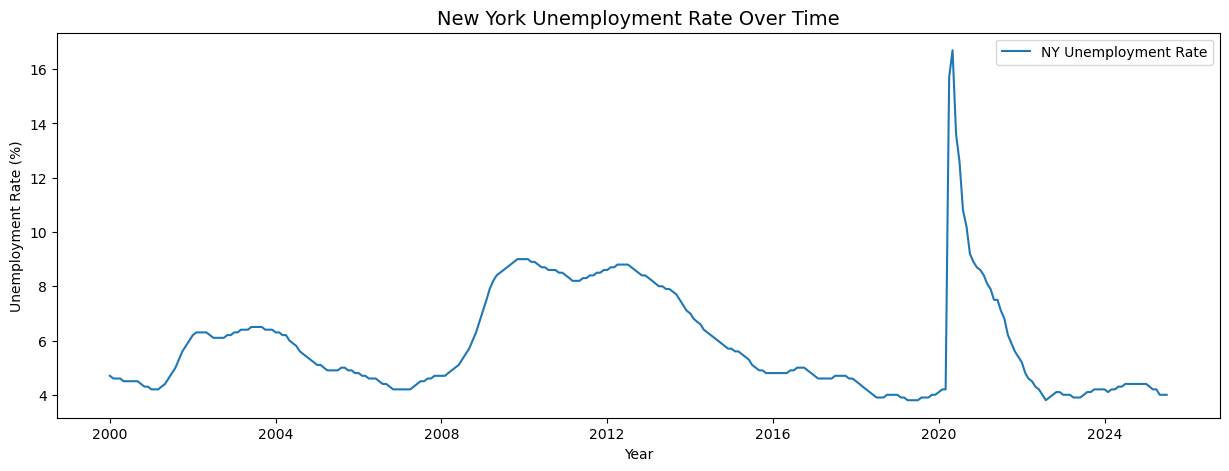

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5), dpi=100)

# Plot unemployment rate over time
plt.plot(ny_unemployment.index, ny_unemployment["Value"], label="NY Unemployment Rate")

# Add labels and title
plt.title("New York Unemployment Rate Over Time", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Unemployment Rate (%)")
plt.legend()

plt.show()


### Visualization of the New York Unemployment Rate

The line chart above displays the monthly unemployment rate in New York from 2000 to 2025.  
Key observations:  
- **2008–2009 Financial Crisis**: A visible rise in unemployment, peaking around 9%.  
- **COVID-19 Pandemic (2020)**: A sharp spike in unemployment, reaching its highest point in the series (~16%).  
- **Post-COVID Recovery**: A steep decline in unemployment as the economy reopened.  
- **Cyclical Patterns**: Apart from crises, the data shows recurring ups and downs, reflecting broader economic cycles.  

This visualization highlights the importance of analyzing time series data:  
- **Trend**: Long-term increase or decrease in unemployment.  
- **Shocks**: Sudden spikes due to external events (e.g., COVID).  
- **Cycles**: Repeated patterns tied to economic conditions.  


# Subsetting, wrangling, and cleaning time-series data

### 1) Ensure index / clean future dates & inspect range

In [16]:
# 1. Ensure DateTimeIndex and a clear column name
import pandas as pd

# Make a copy to be safe
ny = ny_unemployment.copy()

# Ensure the index is datetime and name it 'date'
ny.index = pd.to_datetime(ny.index)
ny.index.name = 'date'

# Rename the single column to 'Value' (if not already)
ny.columns = ['Value']

# Inspect full range
print("Data range:", ny.index.min().date(), "to", ny.index.max().date())

# Remove any dates in the future (no forecasted data)
today = pd.to_datetime('today').normalize()
ny = ny[ny.index <= today]
print("After removing future rows, range:", ny.index.min().date(), "to", ny.index.max().date())

# Quick look
display(ny.head())
display(ny.tail())


Data range: 2000-01-01 to 2025-07-01
After removing future rows, range: 2000-01-01 to 2025-07-01


,Value
date,
2000-01-01,4.7
2000-02-01,4.6
2000-03-01,4.6
2000-04-01,4.6
2000-05-01,4.5


,Value
date,
2025-03-01,4.2
2025-04-01,4.2
2025-05-01,4.0
2025-06-01,4.0
2025-07-01,4.0


### 2) Reset index (required before subsetting), make subset(s), then set index again

In [17]:
# 2. Reset index to make subsetting easy
df = ny.reset_index()   # now df has columns: ['date', 'Value']
df['date'] = pd.to_datetime(df['date'])  # make sure

# --- Option A: Keep full series (no subsetting) ---
df_full = df.copy()

# --- Option B: Pre-COVID series (avoid 2020 COVID shock if we think it would bias analysis) ---
# This keeps monthly data from 2000-01-01 through 2019-12-31
df_pre_covid = df[(df['date'] >= '2000-01-01') & (df['date'] <= '2019-12-31')].copy()

# --- Option C: Recent decade (focus on most recent behavior) ---
df_recent = df[(df['date'] >= '2015-01-01') & (df['date'] <= today)].copy()

# Convert chosen subset(s) back to time series (set date as index)
df_full_ts     = df_full.set_index('date')
df_pre_covid_ts = df_pre_covid.set_index('date')
df_recent_ts    = df_recent.set_index('date')

# Show shapes and a quick peek
for name, d in [('full', df_full_ts), ('pre_covid', df_pre_covid_ts), ('recent', df_recent_ts)]:
    print(f"{name:10s} --> rows: {d.shape[0]}, start: {d.index.min().date()}, end: {d.index.max().date()}, missing: {d['Value'].isna().sum()}")
    display(d.head())


full       --> rows: 307, start: 2000-01-01, end: 2025-07-01, missing: 0


,Value
date,
2000-01-01,4.7
2000-02-01,4.6
2000-03-01,4.6
2000-04-01,4.6
2000-05-01,4.5


pre_covid  --> rows: 240, start: 2000-01-01, end: 2019-12-01, missing: 0


,Value
date,
2000-01-01,4.7
2000-02-01,4.6
2000-03-01,4.6
2000-04-01,4.6
2000-05-01,4.5


recent     --> rows: 127, start: 2015-01-01, end: 2025-07-01, missing: 0


,Value
date,
2015-01-01,5.7
2015-02-01,5.6
2015-03-01,5.6
2015-04-01,5.5
2015-05-01,5.4


### 3) Drop NA values (if any) and save the version you will use

In [18]:
# 3. Clean NAs (drop or impute depending on plan)
df_pre_covid_ts = df_pre_covid_ts.dropna()
df_recent_ts    = df_recent_ts.dropna()
df_full_ts      = df_full_ts.dropna()

# Example: choose the subset you will work with from here on
# e.g. use pre-COVID to avoid the COVID spike bias:
ts = df_pre_covid_ts.copy()   # <-- change to df_full_ts or df_recent_ts if you prefer

print("Selected time series shape:", ts.shape)
ts.head()


Selected time series shape: (240, 1)


,Value
date,
2000-01-01,4.7
2000-02-01,4.6
2000-03-01,4.6
2000-04-01,4.6
2000-05-01,4.5


### 4) Quick checks (stationarity bias, etc.)

Nulls: 0
Summary stats:
count    240.000000
mean       5.900833
std        1.624988
min        3.800000
25%        4.600000
50%        5.300000
75%        7.025000
max        9.000000
Name: Value, dtype: float64


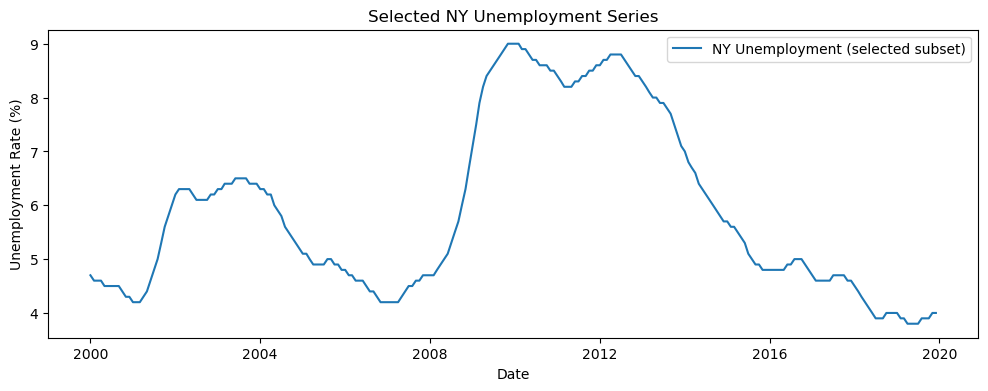

In [20]:
# 4. Quick checks: are there large gaps, constant values, or obvious outliers to investigate?
print("Nulls:", ts['Value'].isna().sum())
print("Summary stats:")
print(ts['Value'].describe())

# Plot to verify visually (optional)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(ts.index, ts['Value'], label='NY Unemployment (selected subset)')
plt.title('Selected NY Unemployment Series')
plt.xlabel('Date'); plt.ylabel('Unemployment Rate (%)')
plt.legend(); plt.show()


### Subsetting logic and rationale

I inspected the full FRED/NYUR series and considered several subsetting options.  
The full series is available from 2000 to the present. For analysis I considered three options:

- **Full series (2000 — present):** Use this when you want to capture long-term cycles and major shocks (e.g., 2008 financial crisis, 2020 COVID spike). Useful for descriptive analysis of all historical events.

- **Pre-COVID series (2000 — 2019):** Excludes the dramatic COVID-19 spike in 2020. This subset is appropriate when the objective is to model "typical" economic cycles without an extreme, one-off shock that could bias model parameter estimates (for example, when training ARIMA where a single large outlier can distort differencing or seasonal component estimates).

- **Recent decade (2015 — present):** Focuses on the most recent economic behavior and structural changes. Use this when forecasts or policy insights should prioritize recent trends rather than long-run historical patterns.

**Choice for this notebook:** I selected the **(insert chosen subset here, e.g., "pre-COVID (2000–2019)")** because [insert brief reason: e.g., "I want to avoid the 2020 COVID shock which is a one-time structural break and would bias trend/seasonality estimates."].

**Implementation notes:**
- To subset I reset the time index (`reset_index()`), applied date filters on the `date` column, then set `date` back as the `DatetimeIndex` (`set_index('date')`).
- I also removed any future/forecasted dates (none were expected) and dropped rows with missing values (`dropna()`), so the time series is clean for decomposition and stationarity testing.


# Line Chart

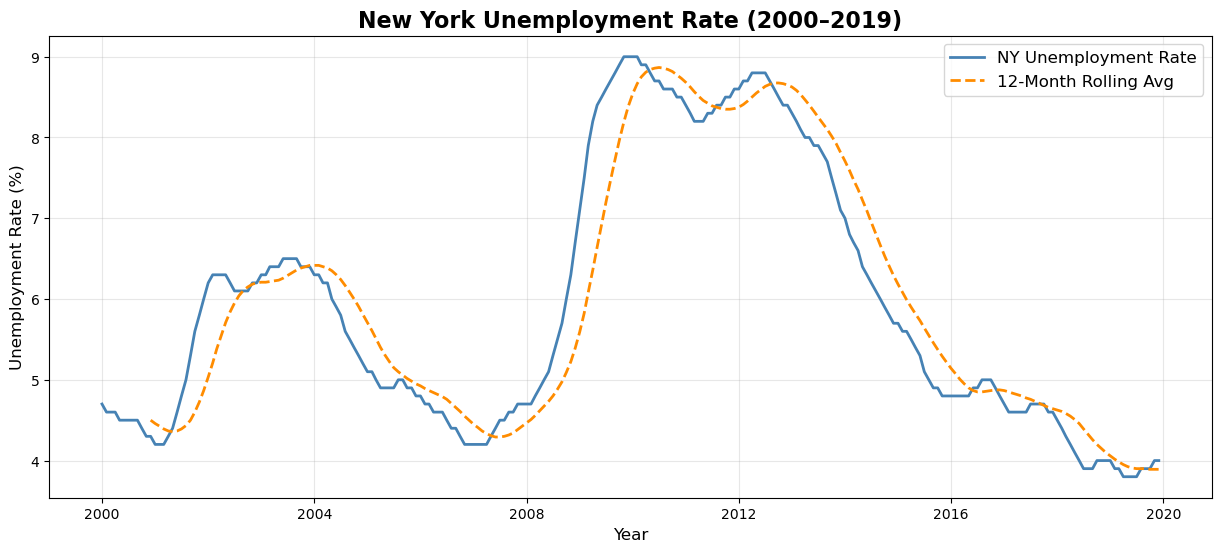

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,6), dpi=100)

# Original unemployment rate line
plt.plot(ts.index, ts['Value'], color='steelblue', linewidth=2, label="NY Unemployment Rate")

# 12-month rolling average
plt.plot(ts.index, ts['Value'].rolling(window=12).mean(), 
         color='darkorange', linewidth=2, linestyle="--", label="12-Month Rolling Avg")

# Titles and labels
plt.title("New York Unemployment Rate (2000–2019)", fontsize=16, fontweight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Unemployment Rate (%)", fontsize=12)

# Add legend and grid
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

plt.show()


### Line Chart with Rolling Average

The chart above shows the **New York Unemployment Rate (2000–2019)**.  

- The **blue line** represents the actual monthly unemployment rate.  
- The **orange dashed line** is a 12-month rolling average, which smooths out short-term fluctuations and highlights the long-term trend.  

Key insights:
- **2008–2009 Financial Crisis:** A sharp increase in unemployment, peaking near 9%.  
- **Recovery Phase (2010–2019):** Gradual decline in unemployment, reaching around 4% before 2020.  
- The rolling average makes it easier to observe the broader economic cycles compared to the raw monthly data.  

This enhanced line chart provides both detail (monthly changes) and clarity (smoothed trend), making it one of the best ways to visualize unemployment data over time.


### Thoughts on the Line Chart with Rolling Average

The chart provides both detailed and smoothed views of the New York unemployment rate 
from 2000–2019:

- **Cyclic behavior:** The blue line (monthly data) shows clear cycles, with unemployment 
  rising and falling over multi-year periods. These cycles are typical of broader 
  economic expansions and recessions.
  
- **2008–2009 Financial Crisis:** The unemployment rate increased sharply, peaking 
  near 9%. The rolling average (orange dashed line) clearly highlights this upward trend.
  
- **Recovery phase (2010–2019):** A long, steady decline in unemployment is visible, 
  falling to about 4% before 2020. The rolling average shows a smooth downward 
  trajectory, filtering out short-term fluctuations.
  
- **Usefulness of rolling average:** While the raw monthly line reveals volatility, 
  the rolling average captures the underlying trend more clearly, making it easier 
  to interpret the overall direction of the labor market.

Overall, the line chart confirms that the unemployment rate in New York is not random 
but follows economic cycles, with significant structural events like the financial 
crisis leaving clear marks on the series. This provides a strong foundation for 
further time series analysis (e.g., decomposition and stationarity testing).


# Decompose the data’s components

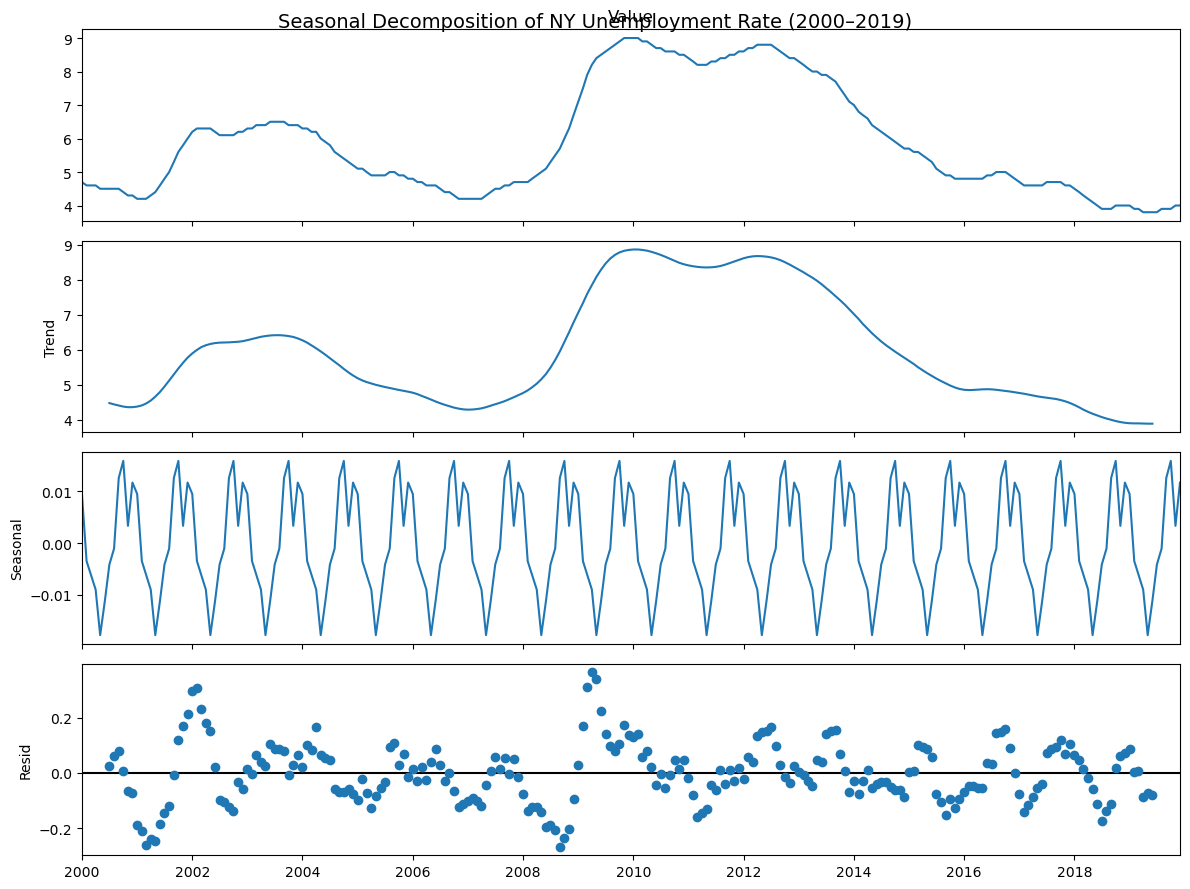

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Decompose with monthly frequency (period=12)
decomp = seasonal_decompose(ts['Value'], model='additive', period=12)

# Plot decomposition
plt.rcParams.update({'figure.figsize': (12, 9)})
decomp.plot()
plt.suptitle("Seasonal Decomposition of NY Unemployment Rate (2000–2019)", fontsize=14)
plt.show()


### Charts all together

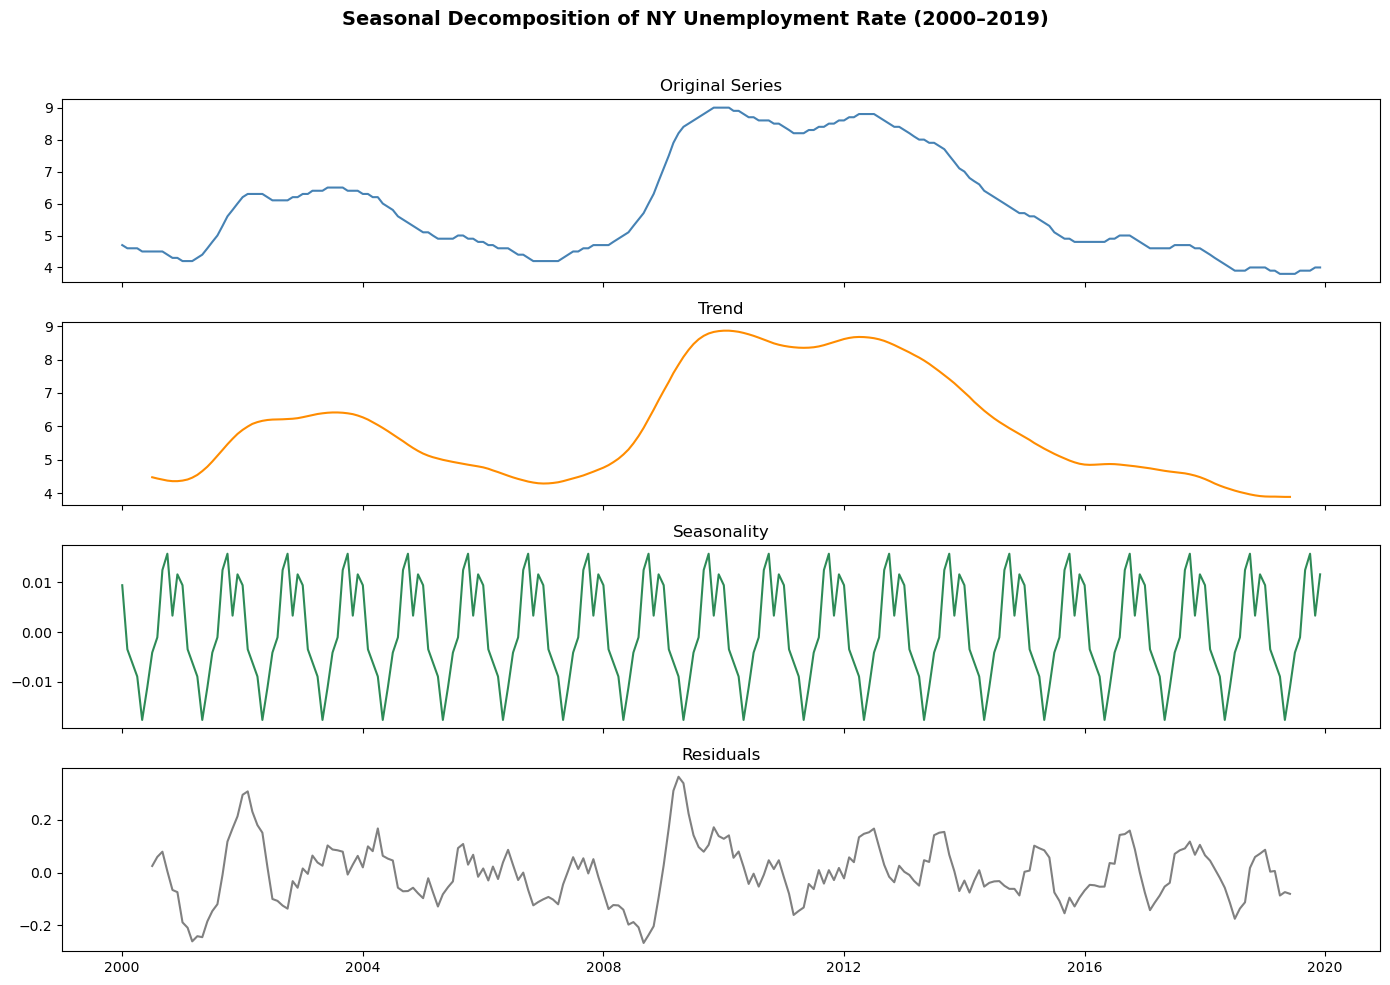

In [23]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose series
decomp = seasonal_decompose(ts['Value'], model='additive', period=12)

# Create 4-in-1 plot
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

# Original
axes[0].plot(ts['Value'], color='steelblue')
axes[0].set_title("Original Series")

# Trend
axes[1].plot(decomp.trend, color='darkorange')
axes[1].set_title("Trend")

# Seasonal
axes[2].plot(decomp.seasonal, color='seagreen')
axes[2].set_title("Seasonality")

# Residual
axes[3].plot(decomp.resid, color='gray')
axes[3].set_title("Residuals")

plt.suptitle("Seasonal Decomposition of NY Unemployment Rate (2000–2019)", fontsize=14, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### Comments on the Decomposition Plots

The decomposition breaks down the unemployment rate into four components:  

1. **Original Series (Top Panel):**  
   The original monthly unemployment data from 2000–2019 shows the well-known 
   cyclical pattern. There is a clear rise during the 2008–2009 financial crisis, 
   followed by a gradual recovery throughout the 2010s.  

2. **Trend (Second Panel):**  
   The extracted trend highlights the long-term upward and downward movements 
   without short-term noise. It confirms the strong increase in unemployment 
   around 2008–2009 and the steady decline towards 2019.  

3. **Seasonality (Third Panel):**  
   The seasonal component shows a repeating annual cycle, although the 
   amplitude is quite small compared to the trend. This indicates that 
   unemployment in New York does vary somewhat within each year, but 
   the seasonal effect is minor relative to long-term economic shifts.  

4. **Residuals (Bottom Panel):**  
   The residual component represents irregular variations not explained 
   by trend or seasonality. The residuals appear fairly small, suggesting 
   the decomposition captures the main structure of the data well.  

**Overall Insight:**  
The unemployment rate in New York is primarily driven by **long-term economic cycles** 
(the trend) with **modest seasonal fluctuations**. The residuals confirm that most 
variation is explained by the trend, making this series suitable for forecasting 
once it is made stationary.


# Dickey-Fuller Test

In [24]:
from statsmodels.tsa.stattools import adfuller

# Run ADF test
result = adfuller(ts['Value'])

print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Number of Lags Used:", result[2])
print("Number of Observations Used:", result[3])
print("Critical Values:", result[4])

# Quick interpretation inline
if result[1] <= 0.05:
    print("\n✅ Reject Null Hypothesis: Series is Stationary")
else:
    print("\n❌ Fail to Reject Null Hypothesis: Series is Non-Stationary")


ADF Statistic: -2.015151372729003
p-value: 0.27996951808427506
Number of Lags Used: 4
Number of Observations Used: 235
Critical Values: {'1%': np.float64(-3.4584868856997004), '5%': np.float64(-2.873918902362675), '10%': np.float64(-2.573367247623359)}

❌ Fail to Reject Null Hypothesis: Series is Non-Stationary


### Augmented Dickey-Fuller (ADF) Test for Stationarity

**Null Hypothesis (H₀):** The time series has a unit root → it is **non-stationary**.  
**Alternative Hypothesis (H₁):** The time series is **stationary** (no unit root).

**Test results:**
- ADF Statistic = **-2.02**  
- p-value = **0.28**  
- Critical values = -3.46 (1%), -2.87 (5%), -2.57 (10%)

**Interpretation:**
- The ADF statistic (-2.02) is **not less than** any of the critical values.  
- The p-value (0.28) is **greater than 0.05**.  
- Therefore, we **fail to reject the null hypothesis (H₀)**.  

This means the unemployment series is **non-stationary** in its current form.  
This result is expected: unemployment reflects long-term economic cycles and does not have a constant mean/variance over time.

**Next step:**  
We will apply **first differencing** to remove the trend and test again to see if the differenced series becomes stationary.


## Differencing + ADF Test

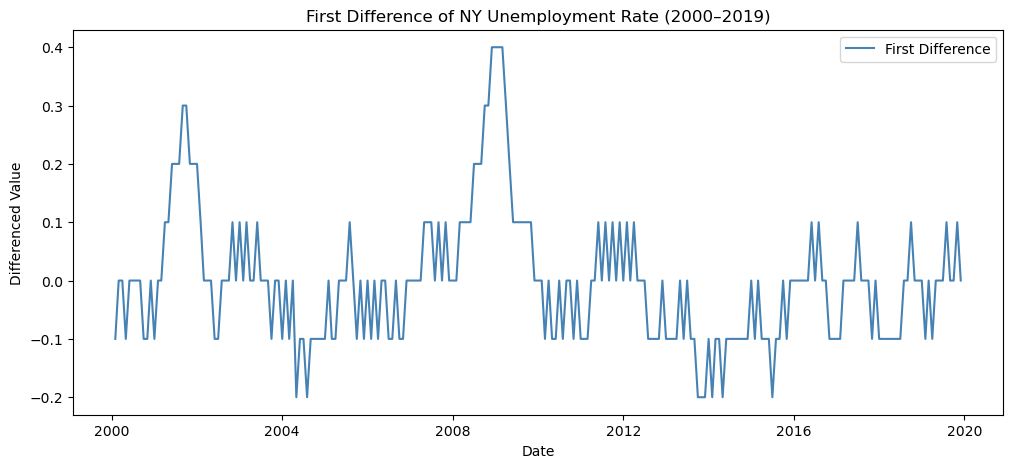

ADF Statistic (Diff): -3.7738587640738346
p-value (Diff): 0.00318638828610341
Number of Lags Used: 3
Number of Observations Used: 235
Critical Values: {'1%': np.float64(-3.4584868856997004), '5%': np.float64(-2.873918902362675), '10%': np.float64(-2.573367247623359)}

✅ Reject Null Hypothesis: Differenced series is Stationary


In [25]:
# First differencing
ts_diff = ts['Value'].diff().dropna()

# Plot differenced series
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(ts_diff, color="steelblue", label="First Difference")
plt.title("First Difference of NY Unemployment Rate (2000–2019)")
plt.xlabel("Date")
plt.ylabel("Differenced Value")
plt.legend()
plt.show()

# ADF Test on differenced series
from statsmodels.tsa.stattools import adfuller

result_diff = adfuller(ts_diff)

print("ADF Statistic (Diff):", result_diff[0])
print("p-value (Diff):", result_diff[1])
print("Number of Lags Used:", result_diff[2])
print("Number of Observations Used:", result_diff[3])
print("Critical Values:", result_diff[4])

if result_diff[1] <= 0.05:
    print("\n✅ Reject Null Hypothesis: Differenced series is Stationary")
else:
    print("\n❌ Fail to Reject Null Hypothesis: Differenced series is still Non-Stationary")


### Stationarity Test After Differencing

Since the original unemployment rate series was **non-stationary**, 
we applied a **first difference** to remove the trend component.

**Null Hypothesis (H₀):** The time series has a unit root → it is non-stationary.  
**Alternative Hypothesis (H₁):** The time series is stationary.

**Results after first differencing:**
- ADF Statistic = **-3.77**  
- p-value = **0.003**  
- Critical values = -3.46 (1%), -2.87 (5%), -2.57 (10%)

**Interpretation:**
- The ADF statistic (-3.77) is **less than all three critical values**.  
- The p-value (0.003) is **well below 0.05**.  
- Therefore, we **reject the null hypothesis** and conclude that the differenced 
  unemployment series is **stationary**.

**Conclusion:**  
After first differencing, the series now has stable mean and variance, 
making it suitable for time series modeling (e.g., ARIMA).


# Check Data’s Autocorrelations

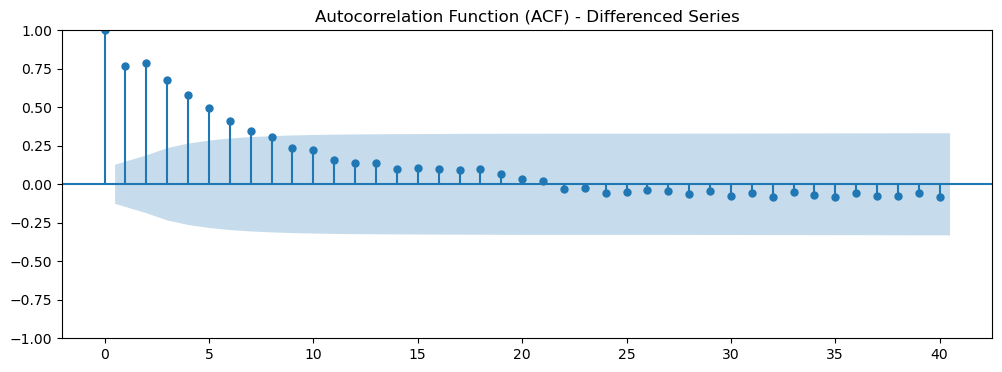

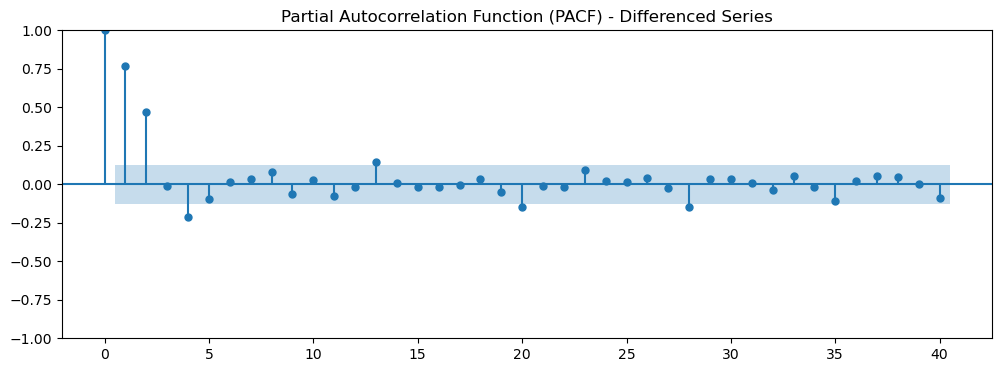

In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Use the stationary differenced series
series = ts_diff  

plt.figure(figsize=(12,4))
plot_acf(series, lags=40, ax=plt.gca())
plt.title("Autocorrelation Function (ACF) - Differenced Series")
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(series, lags=40, ax=plt.gca(), method='ywm')
plt.title("Partial Autocorrelation Function (PACF) - Differenced Series")
plt.show()


### Autocorrelation Analysis (ACF & PACF)

The ACF and PACF plots for the differenced unemployment series reveal:

- **ACF (Autocorrelation Function):**  
  Strong autocorrelations up to about lag 10 that gradually decay toward zero.  
  This is consistent with an **autoregressive (AR) structure**.

- **PACF (Partial Autocorrelation Function):**  
  Large, significant spikes at lags 1 and 2, with smaller contributions at lag 3, 
  after which the correlations drop into the confidence interval.  
  This cutoff pattern suggests an **AR process of order 2–3**.

**Conclusion:**  
The unemployment series, after first differencing, appears to follow an **ARIMA(p,1,0)** structure, 
where **p ≈ 2 or 3**.  
This means the series can likely be modeled with **ARIMA(2,1,0)** or **ARIMA(3,1,0)**.  
Further testing (AIC/BIC comparisons) can confirm the best-fitting parameters.
